## Expedia Hotel Recommendation 

Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

### Loading packages

In [1]:
import pandas as pd
import numpy as np

import warnings

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.utils import shuffle

from implicit.als import AlternatingLeastSquares
from sklearn.decomposition import NMF, PCA
from sklearn.externals import joblib

import scipy.sparse as sparse

from heapq import nlargest 
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import ml_metrics 

import math
from functools import reduce

from heapq import nlargest
from operator import itemgetter

import itertools
import copy

from time import localtime, strftime

### Reading Train Data
File has 37,670,293 records. To reduce amount of RAM used I specified dtype for each variable

In [2]:
print("Reading Train Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
train = pd.read_csv('data/train.csv.gz', 
    compression='gzip',
    # nrows =5000000,
    dtype={
    'user_id': np.int32, 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16, 
    'is_booking': np.int8, 
    'cnt': np.int64, 
    'hotel_cluster': np.int16},
    usecols=['user_id',
             'is_booking',
             'hotel_cluster',
             'srch_destination_id',
             'srch_adults_cnt',
             'srch_children_cnt',
             'srch_rm_cnt',
             'srch_destination_type_id',
             'orig_destination_distance',
             'srch_ci',
             'srch_co',
             'user_location_city',
             'user_location_region',
             'hotel_market',
             'user_location_country', 
             'hotel_country'
            ],
    # parse_dates = ['srch_ci', 'srch_co']
    )
print("Reading Train Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


Reading Train Data... Started at 2018-02-28 21:08:57
Reading Train Data finished at 2018-02-28 21:09:56
 


In [3]:
# Missing imputation for 'orig_destination_distance'
keys_for_mi = (['user_location_city', 'srch_destination_id'], ['user_location_region', 'hotel_market'], ['user_location_country', 'hotel_country'])
dist_imputer = []
median = train["orig_destination_distance"].median()
for keys in keys_for_mi:
    grouping_imputer = train.groupby(keys)["orig_destination_distance"].transform("median")
    train["orig_destination_distance"].fillna(grouping_imputer, inplace=True)
    dist_imputer.append(grouping_imputer)  


train["orig_destination_distance"].fillna(median, inplace=True)
dist_imputer.append(median)
print(train[train["orig_destination_distance"].notnull()].shape[0])
train = train.drop(['user_location_city',
             'user_location_region',
             'hotel_market',
             'user_location_country', 
             'hotel_country'], axis=1)

train['scal_destination_distance'] = StandardScaler().fit_transform(train['orig_destination_distance'].values.reshape(-1, 1))

37670293


In [4]:
print("Formating data. \nStarted at {0} ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

train['srch_ci_dt'] = pd.to_datetime(train['srch_ci'], format="%Y-%m-%d", errors='coerce')
train['srch_co_dt'] = pd.to_datetime(train['srch_co'], format="%Y-%m-%d", errors='coerce')
train = train.drop(['srch_ci', 'srch_co'], axis=1)
train['srch_length_days'] = (train['srch_co_dt'] - train['srch_ci_dt']).dt.days
train['srch_length_days'].fillna(train['srch_length_days'].mean(), inplace=True)
print("Finished at {0} ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


Formating data. 
Started at 2018-02-28 21:10:16 
Finished at 2018-02-28 21:13:54 


In [5]:
train.head()

orig_destination_distance  user_id  srch_adults_cnt  srch_children_cnt  \
0                2234.264160       12                2                  0   
1                2234.264160       12                2                  0   
2                2234.264160       12                2                  0   
3                 913.193176       93                2                  0   
4                 913.625916       93                2                  0   

   srch_rm_cnt  srch_destination_id  srch_destination_type_id  is_booking  \
0            1                 8250                         1           0   
1            1                 8250                         1           1   
2            1                 8250                         1           0   
3            1                14984                         1           0   
4            1                14984                         1           0   

   hotel_cluster  scal_destination_distance srch_ci_dt srch_co_dt  \
0              1                  -0.136471 2014-08-27 2014-08-31   
1              1                  -0.136471 2014-08-29 2014-09-02   
2              1                  -0.136471 2014-08-29 2014-09-02   
3             80                  -0.641746 2014-11-23 2014-11-28   
4             21                  -0.641581 2014-11-23 2014-11-28   

   srch_length_days  
0               4.0  
1               4.0  
2               4.0  
3               5.0  
4               5.0

### Creating Validation set
Select 500,000 for validation set

In [6]:
print("Original shape of Train set is {0}".format(train.shape))
valid = train.sample(n=1000000, random_state=47)
train = train.loc[~train.index.isin(valid.index)]
print('Train set: {0}\nValid set: {1}'.format(train.shape, valid.shape))

Original shape of Train set is (37670293, 13)
Train set: (36670293, 13)
Valid set: (1000000, 13)


### Recomendations based for not covered by models
Recommendations for such users will be made according to *srch_destination_id* popularity

In [7]:
print("Creating dictionary of hotel_clusters by srch_destination_id. \n\tStarted at {0} ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
df_freq = train.groupby(['srch_destination_id', 'is_booking', 'hotel_cluster']).agg(
    {"user_id": len}).rename(columns={'user_id': 'count'}).reset_index()
df_freq['count'] = df_freq.apply(lambda x: x['count']*(10**x['is_booking']), axis=1) 
df_freq = df_freq.groupby(['srch_destination_id', 'hotel_cluster']).agg({'count': 'sum'}).unstack(level='hotel_cluster')
count_sd = df_freq['count'].to_dict('index')
del df_freq
print("\tFinished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


Creating dictionary of hotel_clusters by srch_destination_id. 
	Started at 2018-02-28 21:14:01 
	Finished at 2018-02-28 21:14:19
 


Function for scoring:

In [8]:
def suggest_cluster(row, count_sd):
        n_large = ''
        n_large_list = []
        d_key = row['srch_destination_id']   
        if d_key in count_sd:
            d = count_sd[d_key]
            n_large_list += [i[0] for i in nlargest(5, d.items(), key=itemgetter(1)) if not math.isnan(i[1])]
        n_large_list += [91, 41, 48, 64, 65]
        n_large = reduce(lambda l, x: l+[x] if x not in l else l, n_large_list, [])[:5]
        return n_large

### Discarding users with few events

In [67]:
def discard_low_events(data, record_id, min_events=4):
    user_counts = data[record_id].value_counts()
    low_users = user_counts[user_counts <= min_events].index.values
    return (pd.DataFrame(data.loc[~data[record_id].isin(low_users)]), pd.DataFrame(data.loc[data[record_id].isin(low_users)]))


In [7]:
# set Number of min events to discarding users
num_events = 10
train_high_events, train_low_events = discard_low_events(train, record_id='user_id', min_events=num_events)
print(train_high_events.shape)
print(train_low_events.shape)

(34478749, 9)
(2691544, 9)


In [9]:
def grid_search_learning_curve(base_models, train, valid, param_grid, cluster_vars):
    n_t = train.shape[0]
    n_v = valid.shape[0]
    
    cluster_grid = param_grid['Clustering']
    cluster_model = copy.deepcopy(base_models['Clustering'])
    
    als_grid = param_grid['ALS']
    als_model = copy.deepcopy(base_models['ALS'])
    curves = []
    clusterer = {}
    cluster_keys, cluster_values = zip(*cluster_grid.items())
    for v in itertools.product(*cluster_values):
        cluster_params = dict(zip(cluster_keys, v))
        cur_Cluster_model = copy.deepcopy(cluster_model)
        print_line = []
        for k, v in cluster_params.items():
            setattr(cur_Cluster_model, k, v)
            print_line.append((k, v))

        print('\nClustering: '+' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        print('\tTraining clusterer..')
        with warnings.catch_warnings():
            warnings.simplefilter(
                "ignore",
                category=UserWarning)       
            chunk_size = 100000
            for chunk_start in range(0, n_t, chunk_size):
                if chunk_start % 10000000 == 0:
                    print("\t\tWorking with rows {0}. {1}".format((chunk_start, min(chunk_start + chunk_size, n_t)), strftime("%Y-%m-%d %H:%M:%S", localtime())))
                chunk = train.iloc[chunk_start:min(chunk_start + chunk_size, n_t)]
                chunk = chunk[vars_for_clusters]
                cur_Cluster_model.partial_fit(chunk)
                
        print("Shape of subcluster_centers {0}".format(cur_Cluster_model.subcluster_centers_.shape))
        clusterer[v]=cur_Cluster_model
        print("\tLableling data train. {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
        train['cluster'] = None
        chunk_size = 10000
        for chunk_start in range(0, n_t, chunk_size):
            if chunk_start % 10000000 == 0:
                print("\t\tWorking with rows {0}. {1}".format((chunk_start, min(chunk_start + chunk_size, n_t)), strftime("%Y-%m-%d %H:%M:%S", localtime())))
            chunk = train.iloc[chunk_start:min(chunk_start + chunk_size, n_t)]
            chunk = chunk[vars_for_clusters]
            train.iloc[chunk_start:min(chunk_start + chunk_size, n_t) , train.columns.get_loc('cluster')]= cur_Cluster_model.predict(chunk)
        #cur_Kmeans_model.fit(train[cluster_vars])
        print("Number of clusters: {0}".format(len(train['cluster'].value_counts().index.values)))
        #train['cluster'] = cur_Kmeans_model.predict(train[cluster_vars])
        print("\tLableling validation data. {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
        valid['cluster'] = None
        chunk_size = 10000
        for chunk_start in range(0, n_v, chunk_size):
            chunk = valid.iloc[chunk_start:min(chunk_start + chunk_size, n_v)]
            chunk = chunk[vars_for_clusters]
            valid.iloc[chunk_start:min(chunk_start + chunk_size, n_v) , valid.columns.get_loc('cluster')]= cur_Cluster_model.predict(chunk)
        #valid['cluster'] = cur_Kmeans_model.predict(valid[cluster_vars])
        
        train['event_strength'] = train['is_booking'].apply(lambda x: 10**x)
      
        train_group = train.groupby(['cluster', 'hotel_cluster'])['event_strength'].max().reset_index()

        #Creating a sparse pivot table with users in rows and hotel clusters in columns
        train_pivot_df = train_group.pivot(index='cluster', 
                                                   columns='hotel_cluster', 
                                                   values='event_strength').fillna(0)

        train_pivot_matrix = train_pivot_df.as_matrix()
        train_sparse = sparse.csr_matrix(train_pivot_matrix.T)

        matrix_size = train_pivot_matrix.shape[0]*train_pivot_matrix.shape[1] # Number of possible interactions in the matrix
        num_purchases = np.count_nonzero(train_pivot_matrix) # Number of items interacted with
        sparsity = 100*(1 - (num_purchases/matrix_size))
        print("Matrix sparsity is {0}%".format(sparsity))
        
        als_keys, als_values = zip(*als_grid.items())
        %env OPENBLAS_NUM_THREADS=1
        for v in itertools.product(*als_values):
            als_params = dict(zip(als_keys, v))
            cur_als_model = copy.deepcopy(als_model)
            print_line = []
            for k, v in als_params.items():
                setattr(cur_als_model, k, v)
                print_line.append((k, v))

            print('\nALS: '+' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
            
            print("\tStarted ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
            cur_als_model.fit(train_sparse)
            item_vecs = cur_als_model.item_factors
            user_vecs = cur_als_model.user_factors
            print("\tFinished ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
            

            # Making predictions from decompossed matrix
            all_user_predicted_strength = np.dot(user_vecs, item_vecs.T)
            preds_df = pd.DataFrame(all_user_predicted_strength, columns=train_pivot_df.columns, index=train_pivot_df.index)
            
            num_predictions = 5
            preds_thin_df = pd.DataFrame(preds_df.apply(lambda x: x.sort_values(ascending=False).iloc[:num_predictions].index.tolist(), axis=1),
                            columns=['hotel_cluster_pred'], index=preds_df.index)
            preds_thin_df['hotel_cluster_pred'] = preds_thin_df['hotel_cluster_pred'].apply(lambda x: [x] if type(x) != list else x)
            # print('Shape of prediction thin file: {0}'.format(preds_thin_df.shape))
            # preds_thin_df['hotel_cluster_pred'] = preds_thin_df['hotel_cluster_pred'].apply(lambda x: x +  if len(x) < num_predictions else x)
            
            train_scored = train.merge(preds_thin_df.reset_index(), how='left', on='cluster')[['hotel_cluster', 'hotel_cluster_pred', 'cluster', 'srch_destination_id']]
            train_nscr_cnt = train_scored[train_scored['hotel_cluster_pred'].isna()].shape[0]
            if train_nscr_cnt > 0:
                print("\tShape of not scored train set: {0}".format())
                train_not_scored = pd.DataFrame(train_scored.loc[train_scored['hotel_cluster_pred'].isna()])
                train_not_scored['hotel_cluster_pred'] = train_not_scored.apply(lambda x: suggest_cluster(x, count_sd), axis=1)
                train_scored = train_scored[~train_scored['hotel_cluster_pred'].isna()].append(train_not_scored)
            map5_train = ml_metrics.mapk(train_scored[['hotel_cluster']].values.tolist(), train_scored['hotel_cluster_pred'].tolist(), k=5)

            
            valid_scored = valid.merge(preds_thin_df.reset_index(), how='left', on='cluster')[['hotel_cluster', 'hotel_cluster_pred', 'cluster', 'srch_destination_id']]
            valid_nscr_cnt = valid_scored[valid_scored['hotel_cluster_pred'].isna()].shape[0]
            if valid_nscr_cnt > 0:
                print("\tShape of not scored validation set: {0}".format(valid_scored[valid_scored['hotel_cluster_pred'].isna()].shape))
                valid_not_scored = pd.DataFrame(valid_scored.loc[valid_scored['hotel_cluster_pred'].isna()])
                valid_not_scored['hotel_cluster_pred'] = valid_not_scored.apply(lambda x: suggest_cluster(x, count_sd), axis=1)
                valid_scored = valid_scored[~valid_scored['hotel_cluster_pred'].isna()].append(valid_not_scored)
            map5_valid = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].tolist(), k=5)

            curves.append({'params': {'Clustering': cluster_params, 'ALS': als_params},
                           'cluster_labels': train['cluster'], 
                       'sparsity': sparsity,
                       'map@5': {'train': map5_train, 'valid': map5_valid}})
        %env OPENBLAS_NUM_THREADS=8
              
    return curves, clusterer

In [11]:
class_values = np.unique(train['hotel_cluster'].values)
class_weight = compute_class_weight(class_weight='balanced', classes=class_values, y=train['hotel_cluster'].values)
# if train.shape[0] > 2000000:
#    train_sampl = train.sample(frac=0.01, random_state=47)

param_grid = {'ALS':{'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-1, 1e1],
              'alpha': [1, 10, 100]},
              'Clustering': {'n_clusters': [500000]}}

vars_for_clusters = ['scal_destination_distance', 'srch_adults_cnt', 'srch_rm_cnt', 'is_booking', 'srch_length_days']


%env OPENBLAS_NUM_THREADS=1
base_als = AlternatingLeastSquares()
%env OPENBLAS_NUM_THREADS=8
base_kmeans = Birch(compute_labels=False, copy=True, branching_factor=5, threshold=0.05)

base_models = {'Clustering': base_kmeans, 'ALS': base_als}
%time
curves, clusterer = grid_search_learning_curve(base_models, train, valid, param_grid, cluster_vars=vars_for_clusters) 
for val in curves:
    print("{0}| {1}| Sparsity: {2}".format(val['map@5'], val['params'], val['sparsity']))

env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=8
Wall time: 0 ns

Clustering: n_clusters: 500000
	Training clusterer..
		Working with rows (0, 100000). 2018-02-28 21:25:10
		Working with rows (10000000, 10100000). 2018-02-28 21:40:05
		Working with rows (20000000, 20100000). 2018-02-28 21:55:55
		Working with rows (30000000, 30100000). 2018-02-28 22:11:50
Shape of subcluster_centers (103075, 5)
	Lableling data train. 2018-02-28 22:22:28
		Working with rows (0, 10000). 2018-02-28 22:22:29
		Working with rows (10000000, 10010000). 2018-03-01 00:11:00
		Working with rows (20000000, 20010000). 2018-03-01 02:01:16
		Working with rows (30000000, 30010000). 2018-03-01 03:54:06
Number of clusters: 99288
	Lableling validation data. 2018-03-01 05:10:53
Matrix sparsity is 81.4304850535815%
env: OPENBLAS_NUM_THREADS=1

ALS: num_factors: 10 | regularization: 0.0 | alpha: 1
	Started ALS at 2018-03-01 05:20:59
	Finished ALS at 2018-03-01 05:21:04
	Shape of not scored validation set: (54, 4)

A

	Finished ALS at 2018-03-01 06:13:18
	Shape of not scored validation set: (54, 4)

ALS: num_factors: 120 | regularization: 10.0 | alpha: 10
	Started ALS at 2018-03-01 06:14:28
	Finished ALS at 2018-03-01 06:14:33
	Shape of not scored validation set: (54, 4)

ALS: num_factors: 120 | regularization: 10.0 | alpha: 100
	Started ALS at 2018-03-01 06:15:45
	Finished ALS at 2018-03-01 06:15:50
	Shape of not scored validation set: (54, 4)
env: OPENBLAS_NUM_THREADS=8
{'train': 0.026526869219906886, 'valid': 0.02270316666666666}| {'Clustering': {'n_clusters': 500000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 1}}| Sparsity: 81.4304850535815
{'train': 0.024173332439239918, 'valid': 0.020386999999999995}| {'Clustering': {'n_clusters': 500000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 10}}| Sparsity: 81.4304850535815
{'train': 0.026743797765673701, 'valid': 0.022955266666666658}| {'Clustering': {'n_clusters': 500000}, 'ALS': {'num_factors': 10, 'regularization': 0

In [12]:

max_map5 = 0
best_params = {}
for val in curves:
    if max_map5 < val['map@5']['valid']:
        best_params = val
print("{0}| {1}| Sparsity: {2}".format(best_params['map@5'], best_params['params'], best_params['sparsity']))

{'train': 0.049880479093344893, 'valid': 0.046790866666666653}| {'Clustering': {'n_clusters': 500000}, 'ALS': {'num_factors': 120, 'regularization': 10.0, 'alpha': 100}}| Sparsity: 81.4304850535815


In [39]:
# 100000 clusters make 33108
for val in curves:
    print("{0}| {1}| Sparsity: {2}".format(val['map@5'], val['params'], val['sparsity']))

{'train': 0.021769292124403445, 'valid': 0.020436866666666664}| {'Clustering': {'n_clusters': 100000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 1}}| Sparsity: 76.58568925939349
{'train': 0.041493823665402232, 'valid': 0.040302366666666659}| {'Clustering': {'n_clusters': 100000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 10}}| Sparsity: 76.58568925939349
{'train': 0.027602065176080215, 'valid': 0.026535933333333331}| {'Clustering': {'n_clusters': 100000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 50}}| Sparsity: 76.58568925939349
{'train': 0.030275861245789362, 'valid': 0.029153266666666663}| {'Clustering': {'n_clusters': 100000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 100}}| Sparsity: 76.58568925939349
{'train': 0.028715183923893196, 'valid': 0.02736506666666667}| {'Clustering': {'n_clusters': 100000}, 'ALS': {'num_factors': 10, 'regularization': 0.0, 'alpha': 500}}| Sparsity: 76.58568925939349
{'train': 0.03495707

In [38]:
print(train['cluster'].value_counts().shape)

(33108,)


In [42]:
class_values = np.unique(train['hotel_cluster'].values)
class_weight = compute_class_weight(class_weight='balanced', classes=class_values, y=train['hotel_cluster'].values)
#if train.shape[0] > 2000000:
#    train_sampl = train.sample(frac=0.1, random_state=47)

param_grid = {'ALS':{'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2],
              'alpha': [1, 10, 50, 100, 500, 1000]},
              'Clustering': {'n_clusters': [100000], 'batch_size': [300000]}}

vars_for_clusters = ['scal_destination_distance', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'is_booking', 'srch_length_days']

%env OPENBLAS_NUM_THREADS=1
base_als = AlternatingLeastSquares()
%env OPENBLAS_NUM_THREADS=8

base_kmeans = MiniBatchKMeans(random_state=47, compute_labels=False, verbose=True)
base_models = {'Clustering': base_kmeans, 'ALS': base_als}
curves = grid_search_learning_curve(base_models, train, valid, param_grid, cluster_vars=vars_for_clusters)              
print(curves)

env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=8
Clustering: n_clusters: 100000 | batch_size: 300000
	Training clusterer..
		Working with rows (0, 200000). 2018-02-27 11:46:26


KeyboardInterrupt: 

## NMF model by srch_destination_type_id

### Tuning parametrs for NMF model by srch_destination_type_id

In [15]:
lowest_pct = 0.05
num_components = 10

### Function for creating models by groups
This function creates number of models by *segment_var_name* using dictionary *segments*

In [9]:
def mf_by_segment(train_set, segments, segment_var_name , num_components=20):
    mf_pred = {} 
    
    for key, value in segments.items():
        if len(value)>10:
            print_val = value[:10]
            print_val.append('...')
        else:
            print_val = value
        print("Working with segment {0}: |{1} in {2}. len={3}| \n *** {4} ***".format(key,
                                                                             segment_var_name,
                                                                             print_val,
                                                                             len(value),
                                                                             strftime("%Y-%m-%d %H:%M:%S", localtime())))
        
        sample = pd.DataFrame(train_set[train_set[segment_var_name].isin(value)])
        print(sample.shape)
        sample['event_strength'] = sample['is_booking'].apply(lambda x: 10**x)
      
        train_group = sample.groupby(['user_id', 'hotel_cluster'])['event_strength'].max().reset_index()

        #Creating a sparse pivot table with users in rows and hotel clusters in columns
        train_pivot_df = train_group.pivot(index='user_id', 
                                                   columns='hotel_cluster', 
                                                   values='event_strength').fillna(0)

        train_pivot_matrix = train_pivot_df.as_matrix()
        print("\tStarted NMF at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
        model = NMF(n_components=num_components, init='random', random_state=0, l1_ratio=0.1)
        W = model.fit_transform(train_pivot_matrix)
        H = model.components_

        print("\tFinished NMF at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
        # Making predictions from decompossed matrix
        all_user_predicted_strength = np.dot(W, H) 
        preds_df = pd.DataFrame(all_user_predicted_strength, columns=train_pivot_df.columns, index=train_pivot_df.index)
        
        preds_thin_df = pd.DataFrame(preds_df.apply(lambda x: ' '.join([str(i) for i in x.sort_values(ascending=False).iloc[:5].index.values]), axis=1),
                            columns=['hotel_cluster_pred'], index=preds_df.index)
        # Save preditcion df to 
        mf_pred[key] = preds_thin_df
    
    return mf_pred

### Function for scoring datasets
Firstly dataset is scored using NMF models built for groups. If it wasn't score, there is used model built on all data. If there is still users which weren't covered they are scored using top *hotel_cluster*'s by *srch_destination_id*

In [10]:
def score_mf_by_segment(score_set, segments, segment_var_name, mf_pred):
    scored_set = pd.DataFrame()
    for key, value in segments.items():
        if len(value)>10:
            print_val = value[:10]
            print_val.append('...')
        else:
            print_val = value
        print("Scoring with segment {0}: |{1} in {2}. len={3}| \n *** {4} ***".format(key,
                                                                             segment_var_name,
                                                                             print_val,
                                                                             len(value),
                                                                             strftime("%Y-%m-%d %H:%M:%S", localtime())))
        if key == 'all':
            sample = score_set.loc[~(score_set['id'].isin(scored_set['id'].tolist())) ]
            scored_sample = sample.merge(mf_pred[key].reset_index(), how='left', on='user_id')
        else:
            sample = score_set.loc[score_set[segment_var_name].isin(value)]
            print("\tSample size: {0}".format(sample.shape[0]))
            scored_sample = sample.merge(mf_pred[key].reset_index(), how='left', on='user_id').dropna()
            calc_map5 = 'hotel_cluster' in sample.columns.values
            if calc_map5:
                map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
                print('\tMAP@5 of set #{0} scored using NMF is {1}'.format(key, map5))
        
        
        scored_set = scored_set.append(scored_sample)
    
    return scored_set


def score_by_freq_dest_id(score_set, count_sd):
    print("\nScoring with most frequent by 'srch_destination_id'  \n *** {0} ***".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
    score_set['hotel_cluster_pred'] = score_set.apply(lambda x: suggest_cluster(x, count_sd), axis=1)
    return score_set

def score_all(data, segments, segment_var_name, mf_pred, count_sd):
    calc_map5 = 'hotel_cluster' in data.columns.values
    data_scored = score_mf_by_segment(data, segments, segment_var_name, mf_pred)
    scored_sample = data_scored.loc[~data_scored['hotel_cluster_pred'].isna()]
    if calc_map5:
        
        map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
        print('\n*** MAP@5 of set {0} records scored using NMF is {1} ***'.format(scored_sample.shape[0], map5))
    else:
        print('\n*** {0} records scored using NMF ***'.format(scored_sample.shape[0]))
    data_not_scored = pd.DataFrame(data_scored.loc[data_scored['hotel_cluster_pred'].isna()])
    data_scored_2 = score_by_freq_dest_id(data_not_scored, count_sd)
    scored_sample = data_scored_2
    if calc_map5:
        map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
        print('\n *** MAP@5 of set {0} records scored using srch_destination preferences is {1} ***'.format(scored_sample.shape[0], map5))
    else:
        print('\n ***{0} records scored using srch_destination preferences ***'.format(scored_sample.shape[0]))
    scored_all = data_scored[~data_scored['hotel_cluster_pred'].isna()].append(data_scored_2)
    return scored_all
    

### Creating segmentation
Create segmentation of data set using *srch_destination_type_id*

If population of the group is greater than lowest_pct(0.05) then separate model will be created

In [18]:
segment_var_name = 'srch_destination_type_id'
segment_modeling = {}
freq_df = pd.DataFrame(train_high_events[segment_var_name].value_counts())
freq_df['pct'] = freq_df[segment_var_name].apply(lambda x: round(x/train_high_events.shape[0],4))
freq_df = freq_df.reset_index()
print(freq_df)
print()
for index, row in freq_df.iterrows():
    if row['pct'] > lowest_pct:
        segment_modeling[index+1] = [row['index']]
segment_modeling['all'] = freq_df['index'].tolist()
        
mf_dest_type_pred = mf_by_segment(train_set=train_high_events, segments=segment_modeling, segment_var_name=segment_var_name, num_components=num_components)

   index  srch_destination_type_id     pct
0      1                  21594561  0.6189
1      6                   7867098  0.2255
2      3                   2521149  0.0723
3      5                   1654473  0.0474
4      4                   1124357  0.0322
5      8                    124855  0.0036
6      7                      3011  0.0001
7      9                      1416  0.0000
8      0                        12  0.0000
9      2                         1  0.0000

Working with segment 1: |srch_destination_type_id in [1.0]| 
 *** 2018-02-07 08:34:42 ***
	Started NMF at 2018-02-07 08:35:15
	Finished NMF at 2018-02-07 08:36:18
Working with segment 2: |srch_destination_type_id in [6.0]| 
 *** 2018-02-07 08:39:58 ***
	Started NMF at 2018-02-07 08:40:14
	Finished NMF at 2018-02-07 08:40:41
Working with segment 3: |srch_destination_type_id in [3.0]| 
 *** 2018-02-07 08:43:40 ***
	Started NMF at 2018-02-07 08:43:45
	Finished NMF at 2018-02-07 08:44:00
Working with segment all: |srch_desti

### Scoring of validation set

In [33]:
valid['id'] = range(valid.shape[0]) 
valid_scored = score_all(valid,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_dest_type_pred,
                         count_sd=count_sd)
map5 = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("MAP@5 of Validation set is {0}".format(map5))

Scoring with segment 1: |srch_destination_type_id in [1.0]| 
 *** 2018-02-07 09:25:35 ***
(61893, 6)
Scoring with segment 2: |srch_destination_type_id in [6.0]| 
 *** 2018-02-07 09:25:35 ***
(22543, 6)
Scoring with segment 3: |srch_destination_type_id in [3.0]| 
 *** 2018-02-07 09:25:35 ***
(7264, 6)
Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, 8, 7, 9, 0, 2]| 
 *** 2018-02-07 09:25:36 ***
(16115, 6)
MAP@5 of set scored using NMF is 0.11317151256809155
Scoring with most frequent by 'srch_destination_id'  
 *** 2018-02-07 09:25:37 ***
(8273, 7)
MAP@5 of set scored using srch_destination preferences is 0.09603529553970747
MAP@5 of Validation set is 0.11175383333333333


### Scoring Test data for submission

In [29]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_id', 'srch_destination_type_id', 'srch_destination_id'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print("\tTest records: {0}".format(test.shape[0]))

test_submission = score_all(test,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_dest_type_pred,
                         count_sd=count_sd)
test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'srch_destination_id', 'srch_destination_type_id'], axis=1)
print("\tTest submission records: {0}".format(test_submission.shape[0]))
submission_name = "submissions/NMF{0}_events_le{1}_by_dest_type_{2}_subm.csv".format(num_components, num_events, strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)

Reading Test Data... Started at 2018-02-07 09:12:50
Reading Test Data finished at 2018-02-07 09:12:54
 
(2528243, 4)
Scoring with segment 1: |srch_destination_type_id in [1.0]| 
 *** 2018-02-07 09:12:54 ***
(1376502, 4)
Scoring with segment 2: |srch_destination_type_id in [6.0]| 
 *** 2018-02-07 09:12:55 ***
(733482, 4)
Scoring with segment 3: |srch_destination_type_id in [3.0]| 
 *** 2018-02-07 09:12:56 ***
(210685, 4)
Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, 8, 7, 9, 0, 2]| 
 *** 2018-02-07 09:12:57 ***
(999716, 4)
Scoring with most frequent by 'srch_destination_id'  
 *** 2018-02-07 09:12:58 ***
(727242, 5)
(2528243, 2)


## NMF model by clusters built on srch_destination_id

### Tuning parameters for NMF


In [10]:
num_components = 10

n_clusters = 8

### Reading destinations file
To reduce memory usage was used not default dtype

In [11]:
dtype_dest = {}
for i in range(149):
    dtype_dest['d'+str(i+1)] = np.float32
dest = pd.read_csv('data/destinations.csv.gz', compression='gzip', dtype=dtype_dest, index_col='srch_destination_id')

scaler = StandardScaler()
dest = pd.DataFrame(data=StandardScaler().fit_transform(dest.values), columns=dtype_dest.keys(), index=dest.index)


(62106, 10)
(62106, 149)
Building K-means clusters| k=2| 2018-02-08 10:24:29 
	Calculatin silhoute score... 2018-02-08 10:24:34
	For k = 2 The average silhouette_score is 0.4666425883769989



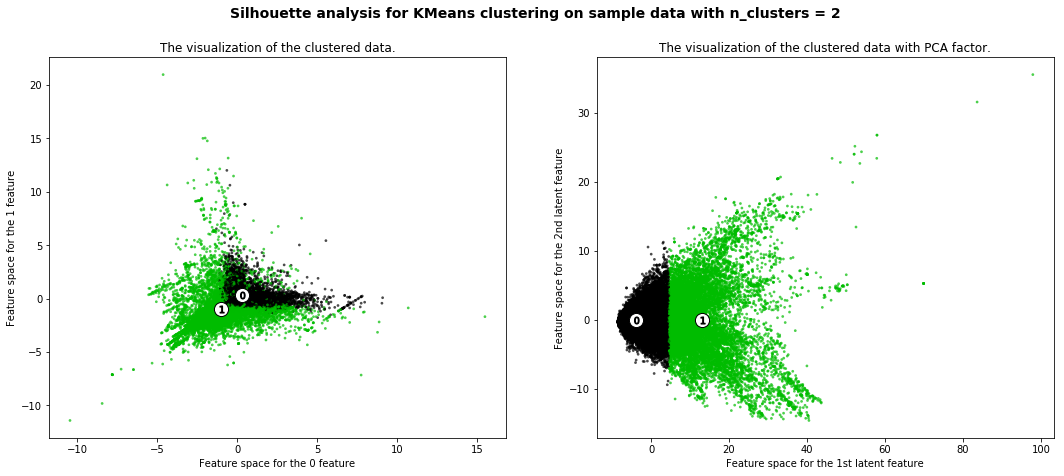

Building K-means clusters| k=3| 2018-02-08 10:24:41 
	Calculatin silhoute score... 2018-02-08 10:24:47
	For k = 3 The average silhouette_score is 0.34931501746177673



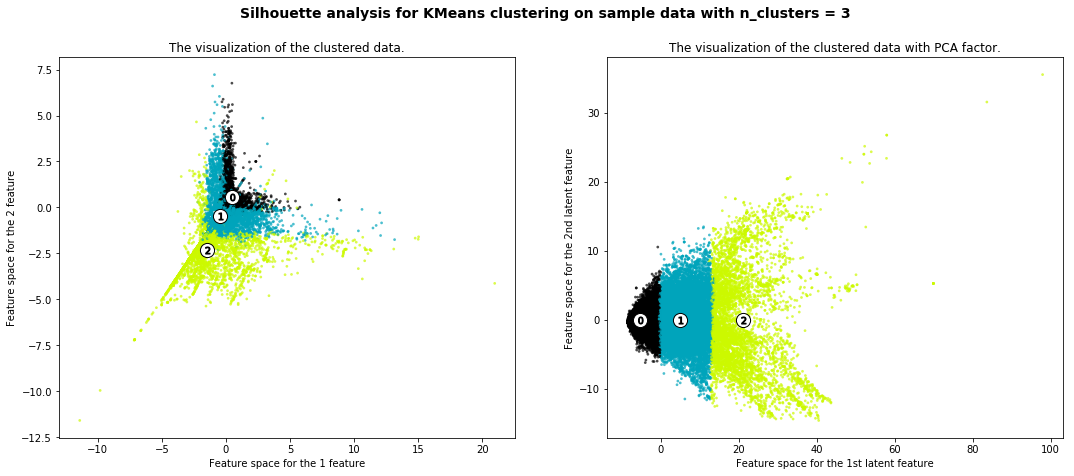

Building K-means clusters| k=4| 2018-02-08 10:24:54 
	Calculatin silhoute score... 2018-02-08 10:25:00
	For k = 4 The average silhouette_score is 0.28568923473358154



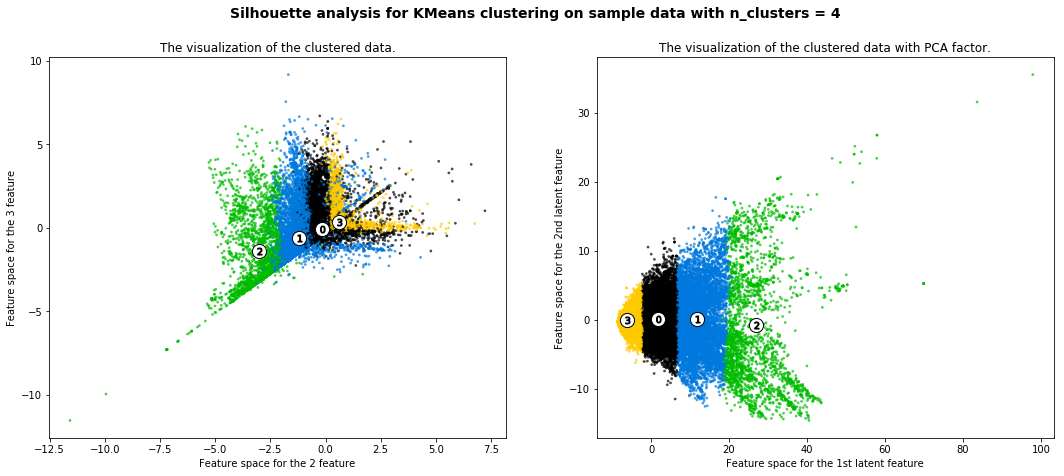

Building K-means clusters| k=5| 2018-02-08 10:25:07 
	Calculatin silhoute score... 2018-02-08 10:25:13
	For k = 5 The average silhouette_score is 0.2683422565460205



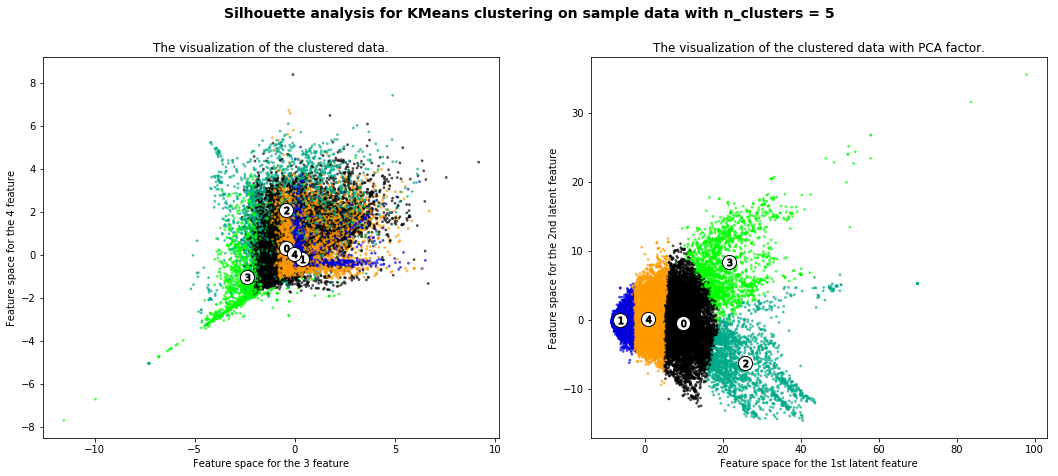

Building K-means clusters| k=6| 2018-02-08 10:25:20 
	Calculatin silhoute score... 2018-02-08 10:25:27
	For k = 6 The average silhouette_score is 0.22269979119300842



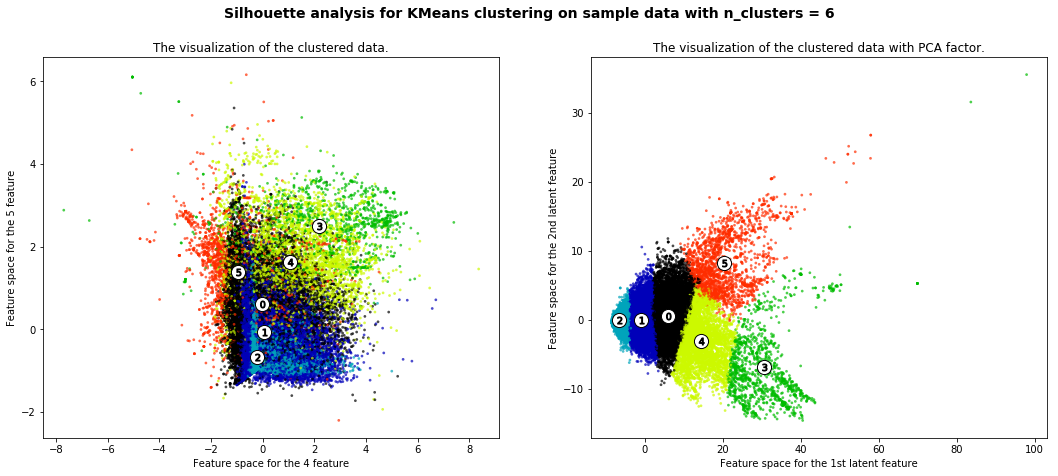

Building K-means clusters| k=7| 2018-02-08 10:25:34 
	Calculatin silhoute score... 2018-02-08 10:25:41
	For k = 7 The average silhouette_score is 0.21179857850074768



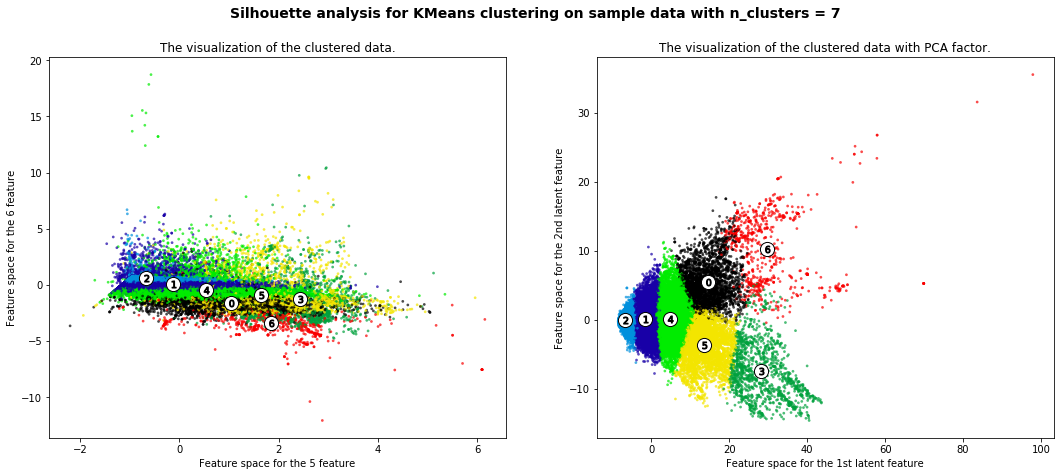

Building K-means clusters| k=8| 2018-02-08 10:25:48 
	Calculatin silhoute score... 2018-02-08 10:25:57
	For k = 8 The average silhouette_score is 0.2144303172826767



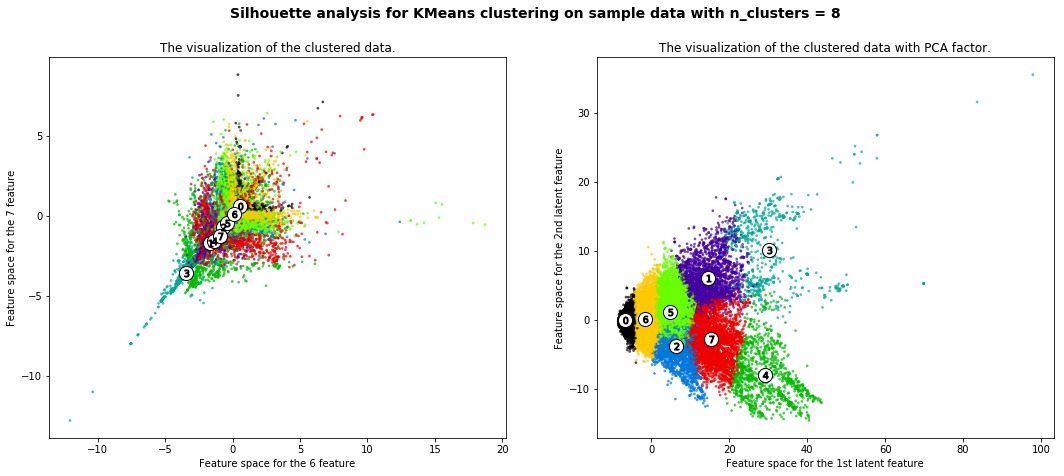

Building K-means clusters| k=9| 2018-02-08 10:26:04 
	Calculatin silhoute score... 2018-02-08 10:26:11
	For k = 9 The average silhouette_score is 0.21211493015289307



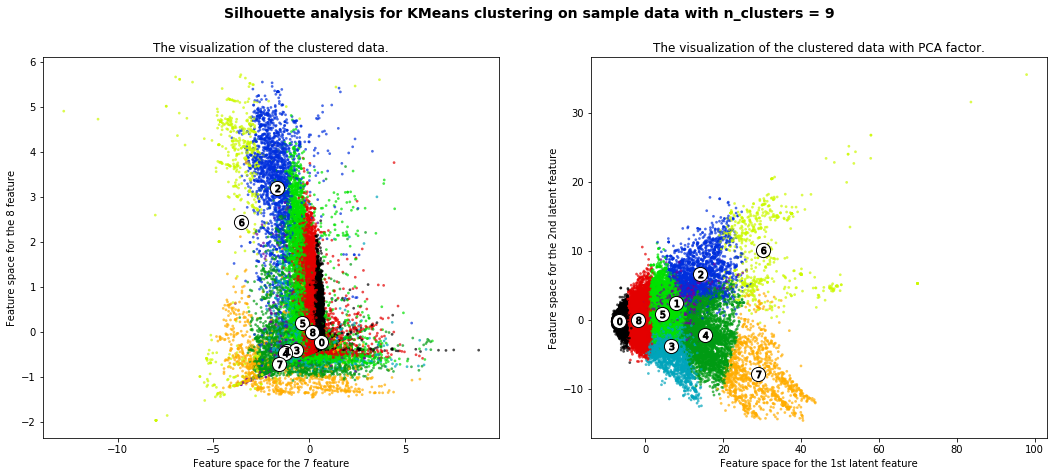

Building K-means clusters| k=10| 2018-02-08 10:26:18 
	Calculatin silhoute score... 2018-02-08 10:26:26
	For k = 10 The average silhouette_score is 0.21112757921218872



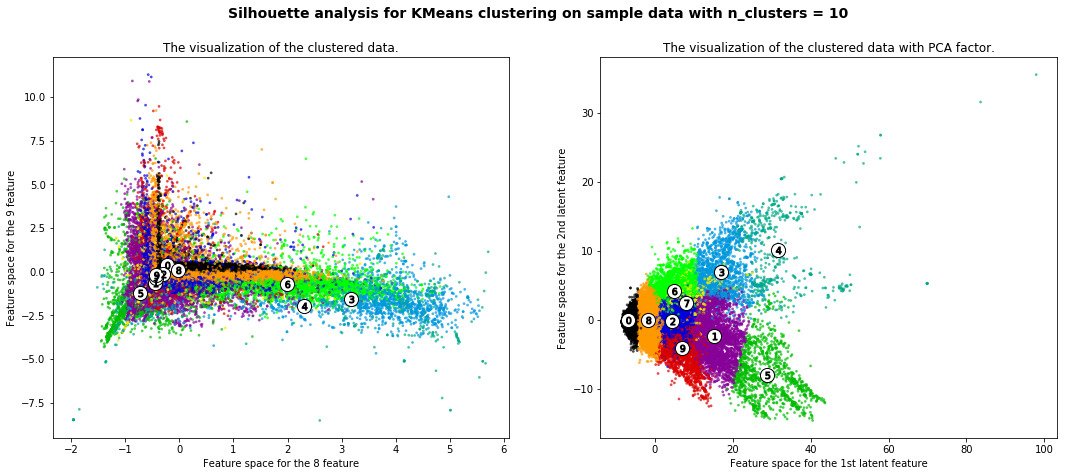

In [12]:
max_clusters = 10
range_n_clusters = range(2,max_clusters+1)

X = dest.values

pca = PCA(n_components=max_clusters)
Xp = pca.fit_transform(X)
print(Xp.shape)
print(X.shape)

for n_clusters in range_n_clusters:
    print("Building K-means clusters| k={0}| {1} ".format(n_clusters, strftime("%Y-%m-%d %H:%M:%S", localtime())))
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 47 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
    cluster_labels = clusterer.labels_
    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print("\tCalculatin silhoute score... {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=12000, random_state=47)
    print("\tFor k = {0} The average silhouette_score is {1}\n".format(n_clusters, silhouette_avg))

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax1.scatter(X[:, n_clusters-2], X[:, n_clusters-1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    ax1.scatter(centers[:, n_clusters-2], centers[:, n_clusters-1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax1.scatter(c[n_clusters-2], c[n_clusters-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("Feature space for the {0} feature".format(n_clusters-2))
    ax1.set_ylabel("Feature space for the {0} feature".format(n_clusters-1))

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xp[:, 0], Xp[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    p_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(p_centers[:, 0], p_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(p_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data with PCA factor.")
    ax2.set_xlabel("Feature space for the 1st latent feature")
    ax2.set_ylabel("Feature space for the 2nd latent feature")

    
    plt.show()


I've decided to choose 8 clusters separation for segmentation of *srch_destination_id*

In [13]:
segment_var_name = 'srch_destination_id'
X = dest.values
clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
cluster_labels = clusterer.labels_
cluster_segm = {}
for i in range(n_clusters):
    cluster_segm[i] = dest.index.values[cluster_labels == i].tolist()
cluster_segm['all'] = dest.index.tolist()

mf_dest_pred = mf_by_segment(train_set=train_high_events, segments=cluster_segm, segment_var_name=segment_var_name, num_components=num_components)


Working with segment 0: |srch_destination_id in [1, 3, 5, 6, 9, 13, 15, 20, 26, 29, '...']. len=25766| 
 *** 2018-02-08 10:28:05 ***
(733940, 5)
	Started NMF at 2018-02-08 10:28:12
	Finished NMF at 2018-02-08 10:28:18
Working with segment 1: |srch_destination_id in [28, 53, 55, 103, 110, 134, 150, 182, 199, 226, '...']. len=3535| 
 *** 2018-02-08 10:29:03 ***
(6642775, 5)
	Started NMF at 2018-02-08 10:29:20
	Finished NMF at 2018-02-08 10:29:56
Working with segment 2: |srch_destination_id in [7, 25, 37, 38, 60, 64, 66, 72, 105, 113, '...']. len=7299| 
 *** 2018-02-08 10:32:33 ***
(3694656, 5)
	Started NMF at 2018-02-08 10:32:46
	Finished NMF at 2018-02-08 10:33:08
Working with segment 3: |srch_destination_id in [82, 107, 154, 278, 325, 384, 404, 511, 513, 529, '...']. len=1669| 
 *** 2018-02-08 10:35:15 ***
(4909299, 5)
	Started NMF at 2018-02-08 10:35:29
	Finished NMF at 2018-02-08 10:35:49
Working with segment 4: |srch_destination_id in [48, 383, 885, 1004, 1196, 1290, 1310, 1365, 142

In [36]:
valid['id'] = range(valid.shape[0]) 
valid_scored = score_all(valid,
                         segments=cluster_segm,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_dest_pred,
                         count_sd=count_sd)
map5 = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("MAP@5 of Validation set is {0}".format(map5))

Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, 148, 163, 167, 196, 197, '...']. len=1565| 
 *** 2018-02-08 09:37:27 ***
	Sample size: 22188
	MAP@5 of set #0 scored using NMF is 0.2753016913721019
Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, 13, 20, 26, 29, 32, '...']. len=16871| 
 *** 2018-02-08 09:37:27 ***
	Sample size: 3106
	MAP@5 of set #1 scored using NMF is 0.40986673089274245
Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, 887, 944, 1102, 1107, 1260, '...']. len=622| 
 *** 2018-02-08 09:37:27 ***
	Sample size: 17459
	MAP@5 of set #2 scored using NMF is 0.26674426836573545
Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, 529, 589, 654, 819, 1042, '...']. len=1123| 
 *** 2018-02-08 09:37:28 ***
	Sample size: 34176
	MAP@5 of set #3 scored using NMF is 0.18312662027561738
Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, 4718, 5097, 6273, 7375, 7727, '...']. len=177

### Scoring Test with hybrid model

In [38]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_id', 'srch_destination_type_id', 'srch_destination_id'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print("\tTest records: {0}".format(test.shape[0]))
test_submission = score_all(test,
                         segments=cluster_segm,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_dest_pred,
                         count_sd=count_sd)
test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'srch_destination_id', 'srch_destination_type_id'], axis=1)
print("\nTest submission records: {0}".format(test_submission.shape[0]))
submission_name = "submissions/NMF{0}_events_le{1}_by_dest_clust{2}_{3}_subm.csv".format(num_components, num_events, n_clusters, strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)

Reading Test Data... Started at 2018-02-08 09:40:03
Reading Test Data finished at 2018-02-08 09:40:08
 
	Test records: 2528243
Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, 148, 163, 167, 196, 197, '...']. len=1565| 
 *** 2018-02-08 09:40:08 ***
	Sample size: 181223
Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, 13, 20, 26, 29, 32, '...']. len=16871| 
 *** 2018-02-08 09:40:08 ***
	Sample size: 40309
Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, 887, 944, 1102, 1107, 1260, '...']. len=622| 
 *** 2018-02-08 09:40:09 ***
	Sample size: 79099
Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, 529, 589, 654, 819, 1042, '...']. len=1123| 
 *** 2018-02-08 09:40:09 ***
	Sample size: 139521
Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, 4718, 5097, 6273, 7375, 7727, '...']. len=177| 
 *** 2018-02-08 09:40:10 ***
	Sample size: 105885
Scoring with segment 5: |srch_destination_id

### NMF model by search Check In month

In [11]:
num_components = 10

In [12]:
segment_var_name = 'ci_month'
segment_modeling = {}
freq_df = pd.DataFrame(train_high_events[segment_var_name].value_counts())
freq_df['pct'] = freq_df[segment_var_name].apply(lambda x: round(x/train_high_events.shape[0],4))
freq_df = freq_df.reset_index()
print(freq_df)
print()
for index, row in freq_df.iterrows():
    segment_modeling[index+1] = [row['index']]
segment_modeling['all'] = freq_df['index'].tolist()
        
mf_ci_month_pred = mf_by_segment(train_set=train_high_events, segments=segment_modeling, segment_var_name=segment_var_name, num_components=num_components)

   index  ci_month     pct
0    Dec   4000596  0.1160
1    Aug   3877976  0.1125
2    Jul   3376341  0.0979
3    Oct   3185730  0.0924
4    Sep   2981619  0.0865
5    Nov   2906956  0.0843
6    Jun   2750960  0.0798
7    May   2591014  0.0751
8    Apr   2359355  0.0684
9    Mar   2326280  0.0675
10   Jan   2210193  0.0641
11   Feb   1871629  0.0543
12   NaT     40100  0.0012

Working with segment 1: |ci_month in ['Dec']. len=1| 
 *** 2018-02-13 22:33:59 ***
(4000596, 9)
	Started NMF at 2018-02-13 22:34:03
	Finished NMF at 2018-02-13 22:34:38
Working with segment 2: |ci_month in ['Aug']. len=1| 
 *** 2018-02-13 22:35:38 ***
(3877976, 9)
	Started NMF at 2018-02-13 22:35:42
	Finished NMF at 2018-02-13 22:36:08
Working with segment 3: |ci_month in ['Jul']. len=1| 
 *** 2018-02-13 22:37:09 ***
(3376341, 9)
	Started NMF at 2018-02-13 22:37:13
	Finished NMF at 2018-02-13 22:37:24
Working with segment 4: |ci_month in ['Oct']. len=1| 
 *** 2018-02-13 22:38:21 ***
(3185730, 9)
	Started NMF at 20

In [13]:
valid['id'] = range(valid.shape[0]) 
valid_scored = score_all(valid,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_ci_month_pred,
                         count_sd=count_sd)
map5 = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("MAP@5 of Validation set is {0}".format(map5))

Scoring with segment 1: |ci_month in ['Dec']. len=1| 
 *** 2018-02-13 23:07:17 ***
	Sample size: 58295
	MAP@5 of set #1 scored using NMF is 0.12458647712082914
Scoring with segment 2: |ci_month in ['Aug']. len=1| 
 *** 2018-02-13 23:07:18 ***
	Sample size: 56148
	MAP@5 of set #2 scored using NMF is 0.12228449034681062
Scoring with segment 3: |ci_month in ['Jul']. len=1| 
 *** 2018-02-13 23:07:19 ***
	Sample size: 48573
	MAP@5 of set #3 scored using NMF is 0.12648836404142583
Scoring with segment 4: |ci_month in ['Oct']. len=1| 
 *** 2018-02-13 23:07:19 ***
	Sample size: 46383
	MAP@5 of set #4 scored using NMF is 0.13181483791520734
Scoring with segment 5: |ci_month in ['Sep']. len=1| 
 *** 2018-02-13 23:07:20 ***
	Sample size: 43535
	MAP@5 of set #5 scored using NMF is 0.13285873173547963
Scoring with segment 6: |ci_month in ['Nov']. len=1| 
 *** 2018-02-13 23:07:20 ***
	Sample size: 42454
	MAP@5 of set #6 scored using NMF is 0.13001291274672572
Scoring with segment 7: |ci_month in ['J

In [17]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_id', 'srch_destination_type_id', 'srch_destination_id', 'date_time', 'srch_ci'],
    parse_dates = ['date_time', 'srch_ci'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print("\tTest records: {0}".format(test.shape[0]))
test['date_month'] = test['date_time'].dt.strftime('%b')
test['ci_month'] = pd.to_datetime(test['srch_ci'], format="%Y-%m-%d", errors='coerce').dt.strftime('%b')
test_submission = score_all(test,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_ci_month_pred,
                         count_sd=count_sd)
test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'srch_destination_id', 'srch_destination_type_id', 'date_time', 'srch_ci', 'date_month', 'ci_month'], axis=1)
print("\nTest submission records: {0}".format(test_submission.shape[0]))
submission_name = "submissions/NMF{0}_events_le{1}_by_сi_month_{2}_subm.csv".format(num_components, num_events,  strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)

Reading Test Data... Started at 2018-02-13 23:55:44
Reading Test Data finished at 2018-02-13 23:56:08
 
	Test records: 2528243
Scoring with segment 1: |ci_month in ['Dec']. len=1| 
 *** 2018-02-13 23:56:26 ***
	Sample size: 193393
Scoring with segment 2: |ci_month in ['Aug']. len=1| 
 *** 2018-02-13 23:56:26 ***
	Sample size: 256782
Scoring with segment 3: |ci_month in ['Jul']. len=1| 
 *** 2018-02-13 23:56:26 ***
	Sample size: 267581
Scoring with segment 4: |ci_month in ['Oct']. len=1| 
 *** 2018-02-13 23:56:27 ***
	Sample size: 209645
Scoring with segment 5: |ci_month in ['Sep']. len=1| 
 *** 2018-02-13 23:56:27 ***
	Sample size: 225657
Scoring with segment 6: |ci_month in ['Nov']. len=1| 
 *** 2018-02-13 23:56:28 ***
	Sample size: 172424
Scoring with segment 7: |ci_month in ['Jun']. len=1| 
 *** 2018-02-13 23:56:28 ***
	Sample size: 235142
Scoring with segment 8: |ci_month in ['May']. len=1| 
 *** 2018-02-13 23:56:29 ***
	Sample size: 235560
Scoring with segment 9: |ci_month in ['Ap